In [255]:
import pandas as pd
import json
from globals import BASE_DIR
import os
import matplotlib.pyplot as plt
import random
from postprocess_baseline_top_k import dataset_metadata
from evaluation_metrics import ndcg, calculate_arp_poplift, evaluation_user_group_means

top_k_eval = 10

available_datasets = ["brightkite", "foursquaretky", "gowalla", "snowcard", "yelp"]

dataset = "snowcard"

#valid_popularity = "business_popularity:float"
valid_popularity = "item_pop"
recommendation_dirpart = "recommendations"

In [256]:
def process_top_k_json(input_file, output_file, k=10):
    """
    Process top-k recommendations from a JSON file, keeping only the item IDs for each user.

    Args:
    - input_file (str): Path to the original JSON file.
    - output_file (str): Path to save the processed JSON file.
    - k (int): Number of top-k recommendations to keep per user.
    """
    os.makedirs(os.path.dirname(output_file), exist_ok=True)
    
    try:
        with open(input_file, 'r') as infile:
            data = json.load(infile)

        top_k_result = {}
        for user_id, recommendations in data.items():
            if recommendations and isinstance(recommendations[0], dict):
                item_ids = recommendations[0]["item_id"][:k]
                top_k_result[user_id] = item_ids

        with open(output_file, 'w') as outfile:
            json.dump(top_k_result, outfile, indent=4)
        print(f"Processed file saved to: {output_file}")
    
    except Exception as e:
        print(f"Error processing {input_file}: {e}")

In [257]:
def create_model_directories(dataset, data, base_dir, recommendation_dirpart):
    model_directories = {}
    methods = ["baseline", "cp", "cp_min_js", "upd"]

    def recommender_dir_combiner(dataset, modelpart, method):
        return f"{base_dir}{dataset}_dataset/{recommendation_dirpart}/{modelpart}/{method + '/'}top_k_recommendations.json"

    for result in data:
        model_name = result["model"]
        model_directories[model_name] = {}
        
        for method in methods:
            model_directories[model_name][method] = recommender_dir_combiner(dataset, result["directory"], method)
    
    return model_directories

def sample_user_groups(user_groups, sample_size=100):
    sampled_groups = {}
    for group, ids in user_groups.items():
        if len(ids) >= sample_size:
            sampled_groups[group] = random.sample(ids, sample_size)
        else:
            print(f"Warning: Group '{group}' has less than {sample_size} users. Sampling all users.")
            sampled_groups[group] = ids
    return sampled_groups


def open_ground_truth_user_group(dataset, valid_popularity=valid_popularity):

    # Stays the same across all models 
    train_data = pd.read_csv(f"{BASE_DIR}{dataset}_dataset/processed_data_recbole/{dataset}_sample.train.inter", sep="\t")
    test_data = pd.read_csv(f"{BASE_DIR}{dataset}_dataset/processed_data_recbole/{dataset}_sample.test.inter", sep="\t")
    valid_data = pd.read_csv(f"{BASE_DIR}{dataset}_dataset/processed_data_recbole/{dataset}_sample.valid.inter", sep="\t")

    print("Train data, test data and valid data shapes:")
    print(train_data.shape, test_data.shape, valid_data.shape)
    #valid_data = pd.read_csv(f"{BASE_DIR}{dataset}_dataset/processed_data_recbole/{dataset}_sample.valid.inter", sep="\t") # originale struktur !!!
    train_data = pd.concat([train_data, valid_data])
    user_group_dir = f"{BASE_DIR}{dataset}_dataset/{dataset}_user_id_popularity.json"
    with open(user_group_dir) as f:
        user_groups = json.load(f)

    # checkin_df = pd.read_csv(
    #     f"{BASE_DIR}{dataset}_dataset/processed_data_recbole/{dataset}_sample.inter",
    #     sep="\t",
    # )

    checkin_df = train_data.copy()
    
    # Calculate item popularity
    value_counts = checkin_df["item_id:token"].value_counts().reset_index()
    value_counts.columns = ["item_id:token", "count"]
    value_counts[valid_popularity] = value_counts["count"] / len(value_counts)
    checkin_df = checkin_df.merge(
        value_counts[["item_id:token", valid_popularity]],
        on="item_id:token",
        how="left",
    )
    checkin_df.sort_values(by=valid_popularity, ascending=False, inplace=True)
    item_popularity = checkin_df.drop_duplicates(subset="item_id:token", keep="first")[
        ["item_id:token", valid_popularity]
    ]

    h_group = item_popularity.head(int(len(item_popularity) * 0.2))
    h_group["item_pop_group"] = "h"
    t_group = item_popularity.tail(int(len(item_popularity) * 0.2))
    t_group["item_pop_group"] = "t"
    m_group = item_popularity[
        ~item_popularity["item_id:token"].isin(h_group["item_id:token"]) &
        ~item_popularity["item_id:token"].isin(t_group["item_id:token"])
    ]
    m_group["item_pop_group"] = "m"

    item_popularity = pd.concat([h_group, m_group, t_group])
    item_popularity.sort_values(by=valid_popularity, inplace=True, ascending=False)




    upts = checkin_df.groupby("user_id:token")[valid_popularity].mean().reset_index()
    upts.columns = ["user_id:token", "upts"]
    return train_data, test_data, user_groups, item_popularity, upts


In [258]:
data = dataset_metadata(dataset, recommendation_dirpart)

In [259]:
model_dirs = create_model_directories(dataset, data, BASE_DIR, recommendation_dirpart)

In [260]:
def unstack_recommendations(df):
    # Repeat each user_id for the length of their item_id:token list
    unstacked_df = df.explode(["item_id:token"]).reset_index(drop=True)
    return unstacked_df

In [261]:
def top_k_to_df(recommender_dir, top_k_eval=top_k_eval):
    # Load the JSON data
    with open(recommender_dir) as f:
        data = json.load(f)

    # Initialize a list to store the recommendations
    base_recommendations = []

    # Iterate through the data and structure it for DataFrame
    for user, items in data.items():
        for item in items:
            base_recommendations.append({
                "user_id:token": user,
                "item_id:token": item
            })

    # Create a DataFrame from the structured recommendations
    base_df = pd.DataFrame(base_recommendations)

    # Assuming `unstack_recommendations` is a function you want to apply here:
    base_df = unstack_recommendations(base_df)

    df = base_df.groupby('user_id:token').head(top_k_eval)

    return df


In [262]:
train_data, test_data, user_groups, item_popularity, upts = open_ground_truth_user_group(dataset)
user_groups['all'] = user_groups['high'] + user_groups['medium'] + user_groups['low']

Train data, test data and valid data shapes:
(48895, 3) (15857, 3) (11583, 3)


/var/folders/9q/p0b6nwnd5071040x3849mdvc0000gn/T/ipykernel_4333/2055348030.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  h_group["item_pop_group"] = "h"
/var/folders/9q/p0b6nwnd5071040x3849mdvc0000gn/T/ipykernel_4333/2055348030.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t_group["item_pop_group"] = "t"
/var/folders/9q/p0b6nwnd5071040x3849mdvc0000gn/T/ipykernel_4333/2055348030.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

In [263]:
def create_pop_distributions(data):
    data = data.merge(item_popularity, on="item_id:token", how="left")
    g1 = data.loc[data["user_id:token"].isin(user_groups["high"])].value_counts("item_pop_group", normalize=True).rename("g1")
    g2 = data.loc[data["user_id:token"].isin(user_groups["medium"])].value_counts("item_pop_group", normalize=True).rename("g2")
    g3 = data.loc[data["user_id:token"].isin(user_groups["low"])].value_counts("item_pop_group", normalize=True).rename("g3")
    all = data.value_counts("item_pop_group", normalize=True).rename("all")
    distr_df = pd.DataFrame([g1, g2, g3, all]).fillna(0)
    return distr_df


ground_truth_distr = create_pop_distributions(train_data)

In [264]:
ground_truth_distr

item_pop_group,h,m,t
g1,0.923670,0.075837,0.000492
g2,0.678026,0.316103,0.005871
g3,0.045670,0.914176,0.040153
all,0.634545,0.356427,0.009028


In [265]:
# Function for plotting popularity distribution (no legend inside this function)
def plot_popularity_distribution(ax, distr_df,label):
    
    colors = plt.cm.viridis([0.1, 0.5, 0.9])
    bars = distr_df.plot(kind='bar', stacked=True, ax=ax, color=colors, legend=False, edgecolor='black', linewidth=1.2)
    ax.set_title(f"{label}")
    ax.set_xlabel("User Groups")
    ax.set_ylabel("Item Pop Distribution")
    return distr_df

def plot_line_chart(results, model_name, ax, metric, title):
    """
    Plot scores (nDCG, ARP, PopLift) as line plots for each user group, comparing methods.
    """
    methods = ["baseline", "cp", "cp_min_js", "upd"]
    user_groups = ["high", "medium", "low", "all"]
    group_labels = ["High", "Medium", "Low", "All"]

    # Extract metric scores for each method and user group
    metric_values = {
        method: [results[model_name][method][group][f"{metric}_mean"] for group in user_groups]
        for method in methods
    }

    # Transpose values to plot lines for user groups
    metric_transposed = list(zip(*metric_values.values()))  # Group-wise scores across methods

    # Plot each user group's metric scores as a line plot
    colors = plt.cm.viridis([0.1, 0.5, 0.9, 0.3])
    for idx, group_label in enumerate(group_labels):
        ax.plot(methods, metric_transposed[idx], marker='o', label=group_label, color=colors[idx])

    ax.set_title(f"{title} for {model_name}")
    ax.set_xlabel("Methods")
    ax.set_ylabel(f"{metric.upper()} Score")
    ax.grid(True)



In [266]:
def calculate_deltas(test_data, base_df):
    base_ndcg_scores = ndcg(test_data, base_df)

    ndcg_values = sum(base_ndcg_scores.values()) / len(base_ndcg_scores)

    print(f"nDCG: {ndcg_values:,.5f}")

    
    # calibrated_ndcg_scores = ndcg(test_data, calibrated_df)    
    # ndcg_delta_percentage = {user_id: ((calibrated_ndcg_scores[user_id] - base_ndcg_scores[user_id]) / base_ndcg_scores[user_id]) * 100 
    #                     for user_id in base_ndcg_scores if base_ndcg_scores[user_id] != 0}
    
    # avg_ndcg_delta_percentage = abs(sum(ndcg_delta_percentage.values()) / len(ndcg_delta_percentage))

    # print(calibrated_df)
    # base_arp_scores, base_poplift_scores = calculate_arp_poplift(base_df, item_popularity, user_profile_popularity, valid_popularity)
    # calibrated_arp_scores, calibrated_poplift_scores = calculate_arp_poplift(calibrated_df, item_popularity, user_profile_popularity, valid_popularity)

    # arp_delta_percentage = {user_id: ((calibrated_arp_scores[user_id] - base_arp_scores[user_id]) / base_arp_scores[user_id]) * 100 
    #                     for user_id in base_arp_scores if base_arp_scores[user_id] != 0}
    
    # avg_arp_delta_percentage = abs(sum(arp_delta_percentage.values()) / len(arp_delta_percentage))

    # poplift_delta_percentage = {user_id: ((calibrated_poplift_scores[user_id] - base_poplift_scores[user_id]) / base_poplift_scores[user_id]) * 100 
    #                     for user_id in base_poplift_scores if base_poplift_scores[user_id] != 0}
    
    # avg_poplift_delta_percentage = abs(sum(poplift_delta_percentage.values()) / len(poplift_delta_percentage))

    # print(f"{model_name} Base vs. Calibrated Results")
    # print(f"Abs. nDCG % change: {avg_ndcg_delta_percentage:,.2f}%; base: {sum(base_ndcg_scores.values()) / len(base_ndcg_scores):,.5f}; calibrated: {sum(calibrated_ndcg_scores.values()) / len(calibrated_ndcg_scores):,.5f}")
    # print(f"Abs. ARP % change : {avg_arp_delta_percentage:,.2f}%; base: {sum(base_arp_scores.values()) / len(base_arp_scores):,.5f}; calibrated: {sum(calibrated_arp_scores.values()) / len(calibrated_arp_scores):,.5f}")
    # print(f"Abs. Poplift % change : {avg_poplift_delta_percentage:,.2f}%; base: {sum(base_poplift_scores.values()) / len(base_poplift_scores):,.5f}; calibrated: {sum(calibrated_poplift_scores.values()) / len(calibrated_poplift_scores):,.5f}")
    # print("*"*50)

    #return base_arp_scores, base_poplift_scores, calibrated_arp_scores, calibrated_poplift_scores, base_ndcg_scores, calibrated_ndcg_scores

In [267]:
# base_df = eval_df =  top_k_to_df("/Volumes/Forster Neu/Masterarbeit Data/gowalla_dataset/recommendations/gowalla_sample-BPR-Dec-19-2024_20-23-30/baseline/top_k_recommendations.json", 10)
# calculate_deltas(test_data, base_df)

In [268]:
model_dirs.items()

dict_items([('BPR', {'baseline': '/Volumes/Forster Neu/Masterarbeit Data/snowcard_dataset/recommendations/snowcard_sample-BPR-Jan-22-2025_15-13-47/baseline/top_k_recommendations.json', 'cp': '/Volumes/Forster Neu/Masterarbeit Data/snowcard_dataset/recommendations/snowcard_sample-BPR-Jan-22-2025_15-13-47/cp/top_k_recommendations.json', 'cp_min_js': '/Volumes/Forster Neu/Masterarbeit Data/snowcard_dataset/recommendations/snowcard_sample-BPR-Jan-22-2025_15-13-47/cp_min_js/top_k_recommendations.json', 'upd': '/Volumes/Forster Neu/Masterarbeit Data/snowcard_dataset/recommendations/snowcard_sample-BPR-Jan-22-2025_15-13-47/upd/top_k_recommendations.json'}), ('LORE', {'baseline': '/Volumes/Forster Neu/Masterarbeit Data/snowcard_dataset/recommendations/snowcard_sample-contextpoi-LORE-Jan-22-2025_09-00-00/baseline/top_k_recommendations.json', 'cp': '/Volumes/Forster Neu/Masterarbeit Data/snowcard_dataset/recommendations/snowcard_sample-contextpoi-LORE-Jan-22-2025_09-00-00/cp/top_k_recommendation

Plots saved to 'item_popularity_and_ndcg_comparison.png'


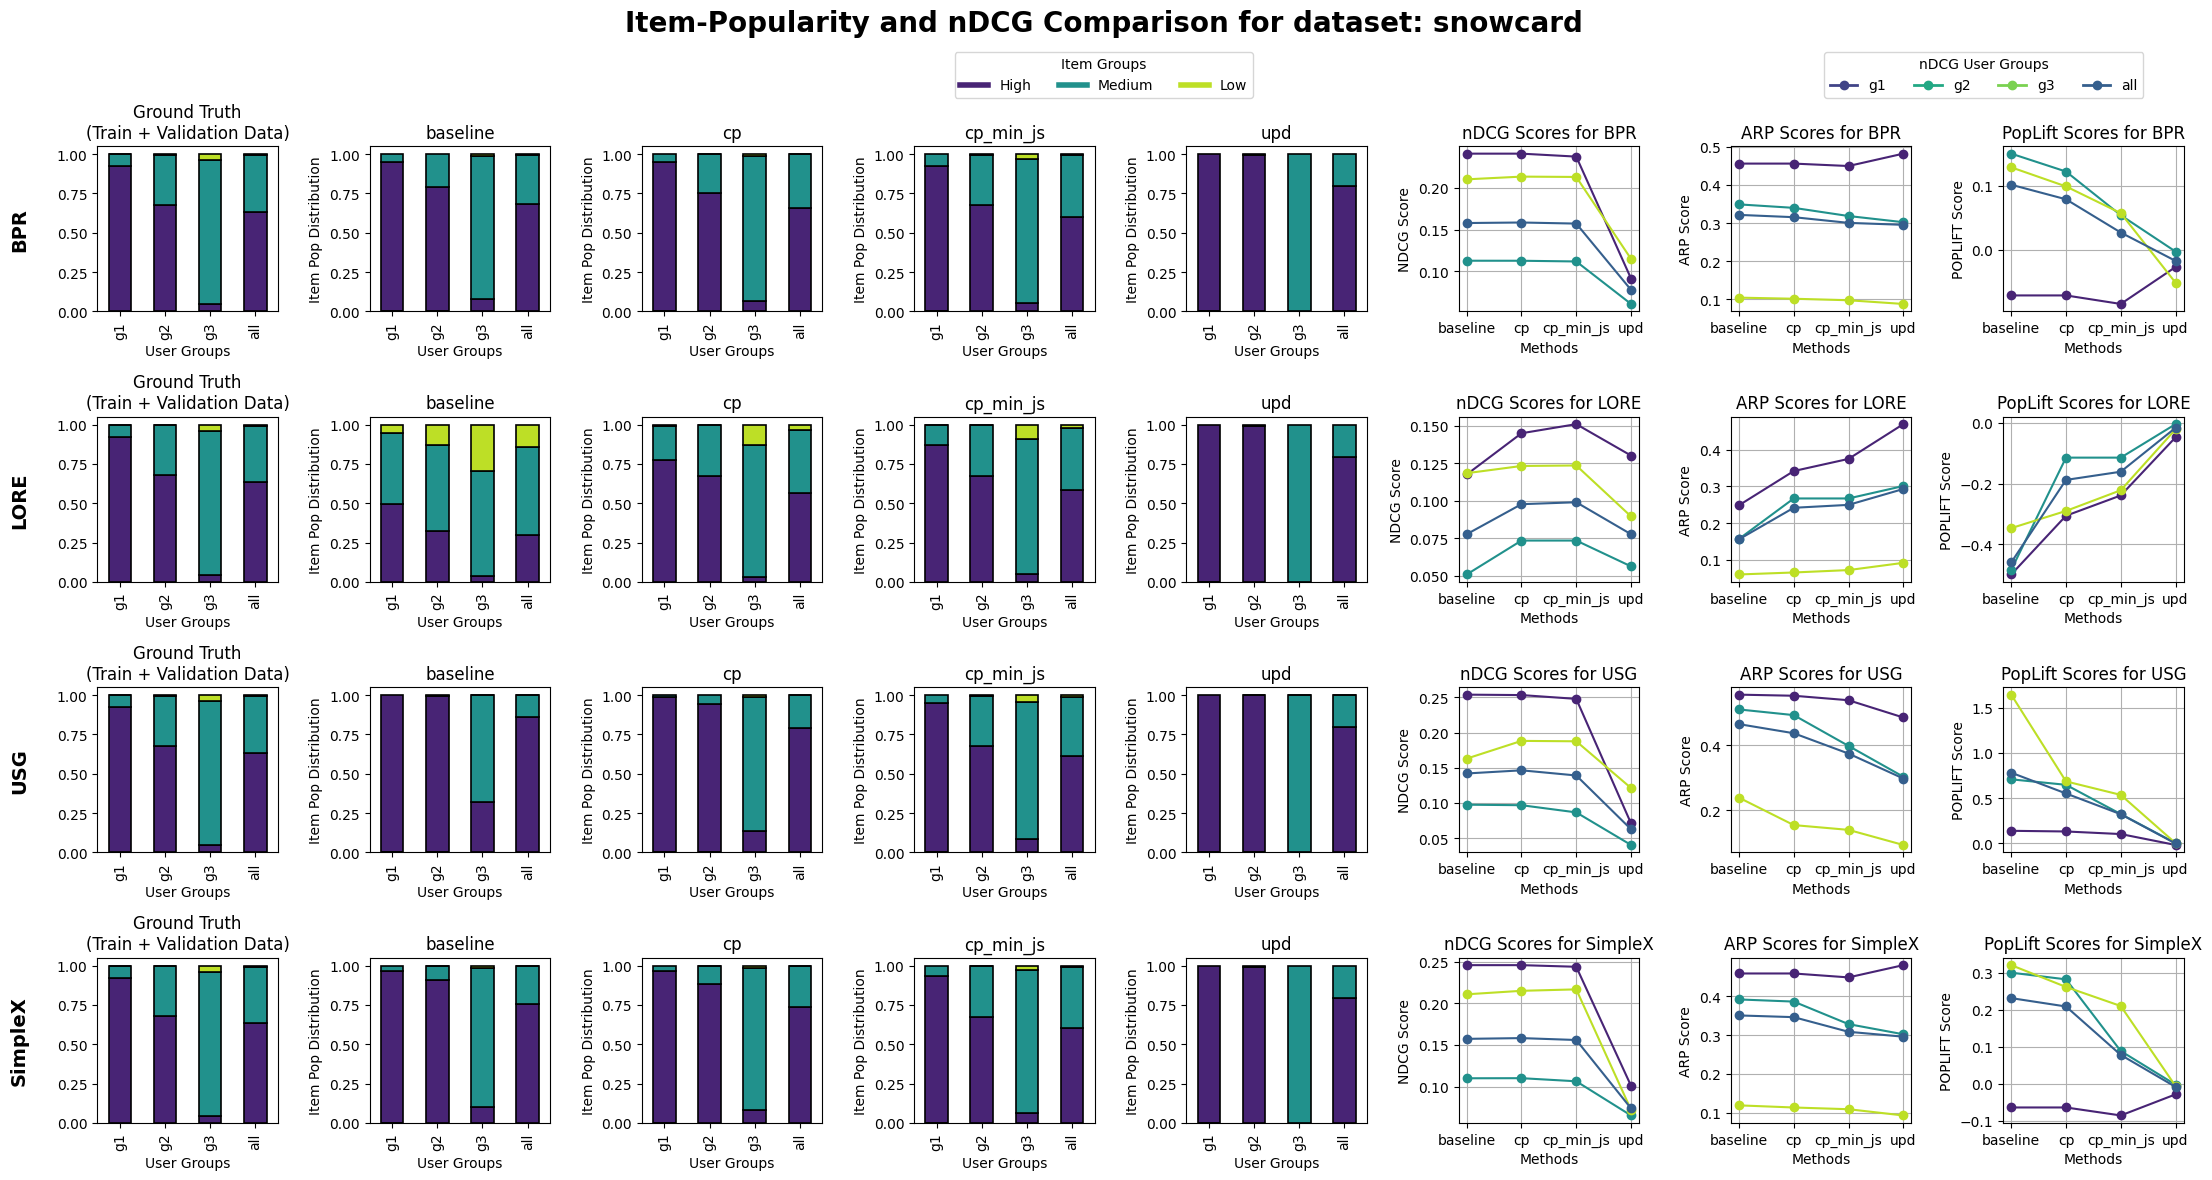

In [269]:
results = {}
fig, axs = plt.subplots(len(model_dirs), 8, figsize=(22, 12))  # Adjusted for nDCG plots

for i, (model_name, methods) in enumerate(model_dirs.items()):
    results[model_name] = {}

    # Plot the ground truth in the first column
    ax = axs[i, 0]
    plot_popularity_distribution(ax, ground_truth_distr, "Ground Truth\n(Train + Validation Data)")

    for j, (method_name, json_file) in enumerate(methods.items()):
        # with open(json_file, 'r') as f:
        #     eval_data = json.load(f)

        df = top_k_to_df(json_file)
        ndcg_scores = ndcg(df, test_data, top_k_eval)
        df_with_item_pop = df.merge(item_popularity, on="item_id:token", how="left")
        arp_scores, poplift_scores = calculate_arp_poplift(df_with_item_pop, item_popularity, upts, valid_popularity)

        group_eval = evaluation_user_group_means(ndcg_scores, arp_scores, poplift_scores, user_groups)
        results[model_name][method_name] = group_eval

        ax = axs[i, j + 1]
        distr_df = create_pop_distributions(df)
        plot_popularity_distribution(ax, distr_df, method_name)

    plot_line_chart(results, model_name, axs[i, -3], "ndcg", "nDCG Scores")
    plot_line_chart(results, model_name, axs[i, -2], "arp", "ARP Scores")
    plot_line_chart(results, model_name, axs[i, -1], "poplift", "PopLift Scores")

    axs[i, 0].set_ylabel(model_name, fontsize=14, weight='bold', labelpad=20)

fig.suptitle(f"Item-Popularity and nDCG Comparison for dataset: {dataset}", fontsize=20, weight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])

handles = [plt.Line2D([0], [0], color=color, lw=4) for color in plt.cm.viridis([0.1, 0.5, 0.9])]
labels = ["High", "Medium", "Low"]
fig.legend(handles, labels, title="Item Groups", loc='upper center', bbox_to_anchor=(0.5, 0.95), ncol=3)

ndcg_handles = [plt.Line2D([0], [0], color=color, lw=2, marker='o') for color in plt.cm.viridis([0.2, 0.6, 0.8, 0.3])]
ndcg_labels = ["g1", "g2", "g3", "all"]
fig.legend(ndcg_handles, ndcg_labels, title="nDCG User Groups", loc='upper center', bbox_to_anchor=(0.9, 0.95), ncol=4)

plt.savefig(f"{BASE_DIR}{dataset}_dataset/plots/item_popularity_and_ndcg_comparison.png")
print("Plots saved to 'item_popularity_and_ndcg_comparison.png'")

In [270]:
# Collect results into rows for CSV output
rows = []
for model_name, methods in results.items():
    for method_name, group_eval in methods.items():
        for group_name, metrics in group_eval.items():
            row = {
                'dataset': dataset,
                'model': model_name,
                'method': method_name,
                'user_group': group_name,
                'ndcg': metrics['ndcg_mean'],
                'arp': metrics['arp_mean'],
                'poplift': metrics['poplift_mean']
            }
            rows.append(row)

# Create a DataFrame from the rows
df_results = pd.DataFrame(rows)

# Save the evaluation results to a CSV file
df_results.to_csv(f'{BASE_DIR}/{dataset}_dataset/evaluation_results.csv', index=False)
# print("Evaluation results have been saved to 'evaluation_results.csv'")

In [271]:
df_results.tail(50)

,dataset,model,method,user_group,ndcg,arp,poplift
14,snowcard,BPR,upd,low,0.114978,0.087990,-0.050982
15,snowcard,BPR,upd,all,0.077919,0.295247,-0.016993
16,snowcard,LORE,baseline,high,0.117430,0.248599,-0.498270
17,snowcard,LORE,baseline,medium,0.050908,0.156458,-0.483219
18,snowcard,LORE,baseline,low,0.118285,0.059291,-0.346334
19,snowcard,LORE,baseline,all,0.077688,0.155453,-0.458852
20,snowcard,LORE,cp,high,0.144865,0.342190,-0.305658
21,snowcard,LORE,cp,medium,0.073468,0.267214,-0.115086
22,snowcard,LORE,cp,low,0.123100,0.064696,-0.289911
23,snowcard,LORE,cp,all,0.097674,0.241706,-0.188165


In [272]:
# Exposure Frequency PLot


# # List of algorithm DataFrames and their names
# algorithm_dfs = {
#     'BPR(Base)': base_df_general1,
#     'BPR(Re-ranked)': calibrated_df_general1,
#     'SimpleX(Re-ranked)': calibrated_df_general2,
#     'SimpleX(Base)': base_df_general2,
#     'LORE(Base)': base_df_context1,
#     'LORE(Re-ranked)': calibrated_df_context1,
#     'USG(Base)': base_df_context2,
#     'USG(Re-ranked)': calibrated_df_context2
# }

# # Dictionary to store sorted frequencies for each algorithm
# item_frequencies = {}

# # Calculate frequency of each item in recommendations for each algorithm
# for algorithm_name, df in algorithm_dfs.items():
#     # Count item frequencies in each DataFrame
#     item_counts = df['item_id:token'].value_counts(normalize=True)  # Normalize to get frequency
#     sorted_counts = item_counts.sort_values(ascending=True).values  # Sort in descending order
#     item_frequencies[algorithm_name] = sorted_counts  # Store sorted frequencies

# # Plotting
# plt.figure(figsize=(12, 6))

# # Plot each algorithm's sorted item frequencies
# for algorithm_name, frequencies in item_frequencies.items():
#     plt.plot(frequencies, label=algorithm_name)

# plt.xlabel('Items (sorted by frequency)')
# plt.ylabel('Recommendation Frequency')
# plt.title('Exposure Frequency of Items Recommended by Different Algorithms')
# plt.legend(title='Algorithms')
# plt.ylim(0, 0.045)  # Adjust as needed based on frequency range
# plt.xlim(0, 8000)  # Adjust as needed based on frequency range
# plt.show()
